# First steps

We developed the following Notebook to start using ReVel. On this first notebook, we show how a Local Linear Explanation(LLE) could notice the important features of an example by removing some specific features.

## Necessary imports

We first import some functionalities from ReVel and some other libraries. Those functionalities are:

1. Preprocessing: function to preprocess the data of Imagenet.
2. Efficientnet: model and pretrained weights so we don't have to train an specific model.
3. From ReVel, Some functionalities to explain the model:
   * Perturbation: to generate the neighbours of the examples to explain.
   * Local Linear Explanations (LLE): to explain the model. We choose to generate explanations with Lime.
   * ReVel: this class abstracts all the evaluation part of the explanations.

In [3]:
import imp
import torch
from torch.utils.data.dataloader import DataLoader
from efficientnet_pytorch import EfficientNet # The black box to be explained
from ReVel.perturbations import get_perturbation # The Revel Framework for the perturbation action of the original image
from ReVel.LLEs import get_xai_model # The Local Linear Explanation developed on the ReVeL framework
from ReVel.revel.revel import ReVel # The evaluation class from ReVel
from ReVel.load_data import load_data
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import wget
import PIL
import torchsummary
import torchvision
import cv2
import json
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# This function is the normalization function used to train the Efficientnet model on ImageNet

def get_input_transform(final_size=None):#(224,224)):     
    def swap_Array(img):
        img = img.clone().detach()
        if img.shape[-1] == 3:
            
            img = img.permute(2,0,1)
        return img
    def resize(img):
        img = cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC)
        return img
    
    centerCrop = torchvision.transforms.CenterCrop(final_size)
    

    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225],)
    
    
    
    transf = torchvision.transforms.Compose([resize,
        torchvision.transforms.ToTensor(),
        centerCrop,
        normalize,
        swap_Array
    ])
    return transf

# Load the name of the classes of the ImageNet dataset

if not os.path.exists('imagenet1000_clsidx_to_labels.txt'):
    wget.download('https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt', 'imagenet1000_clsidx_to_labels.txt')
classes = open('imagenet1000_clsidx_to_labels.txt').read()
import ast
classes = ast.literal_eval(classes)
print(classes)
# classes to dict

# Load the perturbation method to be use in the ReVeL framework
perturbation = get_perturbation(name='square',
                                dim=8,
                                num_classes=len(classes),
                                final_size=(224,224)
                                )

# Load the LLE model to be tested in the ReVeL framework
explainer = get_xai_model(name='LIME',
                          perturbation=perturbation,
                          max_examples=800,
                          dim=10,
                          sigma = 2)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

## Load the example and the model 

To develop a study case, we need to load an instance and a model to explain. In this case, we will use an image from Imagenet and a simple CNN pre-trained model, efficientnet-b2.

Loaded pretrained weights for efficientnet-b2


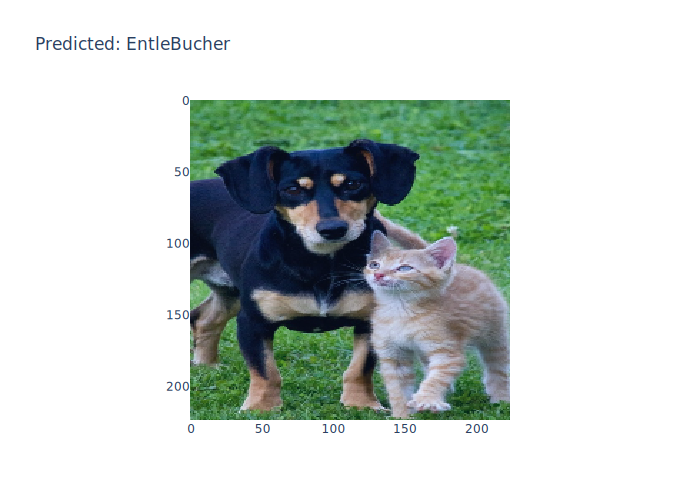

In [4]:
# Download of the image from Imagenet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists('./cat_and_dog.jpg'):
    Image = wget.download('https://images.all-free-download.com/images/graphiclarge/cat_and_dog_206704.jpg', './cat_and_dog.jpg')
image_show = PIL.Image.open('./cat_and_dog.jpg')
image = np.array(image_show)
transform = get_input_transform(final_size=(224,224))
image = transform(image)
# Pretrained model from Efficientnet
model = EfficientNet.from_pretrained('efficientnet-b2')
model.to(device)
model.eval()
output = model(image.unsqueeze(0).to(device))
_, pred = torch.max(output, 1)

#px.imshow(image_show, title=f'Predicted: {classes[pred.item()]}')
fig = go.Figure()
fig.add_trace(go.Image(z=(image.permute(1,2,0)+2.2)*58,name=f'Predicted: {classes[pred.item()]}'))
fig.update_layout(title=f'Predicted: {classes[pred.item()]}')
fig.show(renderer="svg")


## Study of vectors of probabilities

Before studying the explanation, we will study the vectors of probabilities of the model. We will see that the model is very confident about the prediction and how, by removing some features, we can change the prediction. This is due to the fact that those features are important for the model prediction. 

With the following code, we preprocess the image to be used by the model. We also get the prediction of the model and the vector of probabilities. Note that `241` is the label class associated with `EntleBucher`.

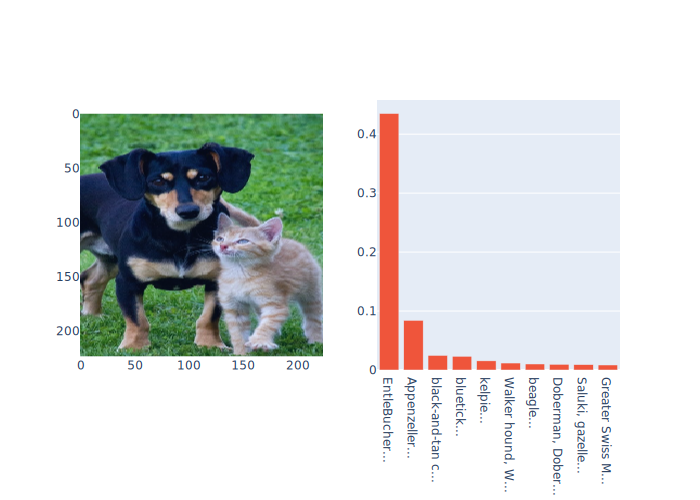

In [5]:
inp = np.array(image_show)
inp = transform(inp).unsqueeze(0)
inp = inp.float()
target = torch.zeros(1000).float().to(device)
target[241] = 1

clase = classes[241]

probabilities = torch.softmax(model(inp.to(device)),dim=1)[0]
clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)


prob_classes = [(classes[int(arg)],float(probabilities[int(arg)]) ) for arg in args[:10]]

figure_probs = px.bar(prob_classes,x=0,y=1,title="Probabilities of the classes")
figure_probs.update_yaxes(range=[0,1],title="Probability")
# Show figure_image and figure_probs on a single figure as subfigures. 
# figure_image is an image and figure_probs is a bar chart.

figure = make_subplots(rows=1, cols=2, specs=[[{"type": "image"}, {"type": "bar"}]])


figure.add_trace(go.Image(z=(inp[0].permute(1,2,0)+2.2)*58), row=1, col=1)
# y delimited to [0,1] to show the probabilities
figure.add_trace(go.Bar(x=[prob_classes[i][0][:15]+"..." for i in range(10)],y=[prob_classes[i][1] for i in range(10)]), row=1, col=2)
figure.show(renderer="svg")

As we can see, the model is very confident about the prediction. The probability of the correct class is about 45% and the following classes have a probability of less than 10%. Let's see what happens if we remove some features:

## Explaining

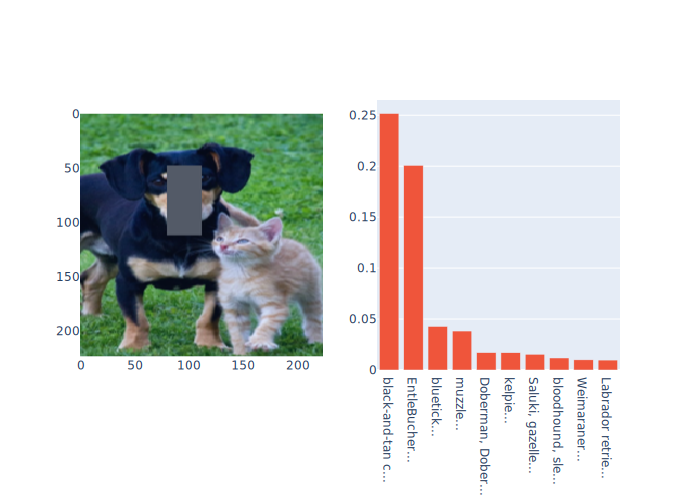

In [6]:
# Genera una perturbacion de inp
inp = np.array(image_show)
inp = torch.Tensor(inp).permute(2,0,1)
inp = torchvision.transforms.Resize((224,224))(inp)
inp = inp.permute(1,2,0).numpy()
neutralImage = explainer.perturbation.fn_neutral_image(inp)
segments = explainer.perturbation.segmentation_fn(inp)
indexes = [26,27]
perturbation = explainer.perturbation.perturbation(img=inp,neutral=neutralImage,segments=segments,indexes=indexes)
perturbation = perturbation.astype(np.uint8)

pert = transform(perturbation)

pert = pert.unsqueeze(0).float().to(device)

prediction = model(pert)
probabilities = torch.softmax(prediction,dim=1)[0]

clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)


prob_classes = [(classes[int(arg)],float(probabilities[int(arg)]) ) for arg in args[:20]]

figure = make_subplots(rows=1, cols=2, specs=[[{"type": "image"}, {"type": "bar"}]])
figure.add_trace(go.Image(z=(pert[0].permute(1,2,0)+2.2)*58), row=1, col=1)
figure.add_trace(go.Bar(x=[prob_classes[i][0][:15]+"..." for i in range(10)],y=[prob_classes[i][1] for i in range(10)]), row=1, col=2)

figure.show(renderer="svg")

As we remove the features related to the `EntleButcher` class, the probability of the correct class decreases and the probability of the other classes increases. This is due to the fact that those features are important for the model prediction. We can notice that the probability of `Black and tan`,`bluetick` and `Doberman` increases, which is the class that is the most similar to the dog in the image. We may think that the features `26` and `27` are the most important features for the prediction of the model. To confirm this, we can use the LLE to explain the model.

## Explanation

To obtain the explanation, we use the `explain_instance` method of the `LLE` class. This method needs the following parameters:
- `instance`: the instance to explain. 
- `model_forward`: the model to explain. This model needs to be a function that receives an example of the type of `instance` and returns a vector of real-valued numbers, that is, the vector is not a probability vector. Each position of the vector corresponds to the presence of certain class on the example.
- `segments`: The segments of the instance. This parameter is used to generate the neighbours of the instance. The neighbours are generated by removing some segments of the instance, each of them is considered a different feature. In this case, we use the segments of the image, which are a group of pixels of the image.

In [7]:
def classify(instance,model=model):
    '''
    This function takes an image and returns the predicted probabilities.
    :param instance: A tensor or numpy array of shape HxWxC
    :return: A tensor of shape Cx1
    '''
    if isinstance(instance, np.ndarray):
        
        instance = np.expand_dims(instance,0)
        
        instance = torch.Tensor(instance).to(device)
        
    else:
        instance = torch.unsqueeze(instance,0)
    
    # instance dims: (N,H,W,C) -> (N,C,H,W)
    
    instance = instance.permute(0,3,1,2)
    
    result = model(instance)
    return result

print(classes[torch.argmax(classify(transform(np.array(image_show)).permute(1,2,0)),dim=1)[0].item()])
neutralImage = explainer.perturbation.fn_neutral_image(transform(np.array(image_show)))
image_to_segment = transform(np.array(image_show))

image_to_segment = image_to_segment.permute(1,2,0)

segments = explainer.perturbation.segmentation_fn(image_to_segment)
to_explain = np.array(image_show)
to_explain = transform(to_explain).permute(1,2,0)


explanation = explainer.explain_instance(to_explain,classify,segments)

EntleBucher


100%|██████████| 800/800 [00:45<00:00, 17.74it/s]


## Explanation visualization

We obtain the explanation of the model by abstracting the fordward function of the model. The `model_forward` function is this abstraction. This function must receive the following parameters:
- `X`: the instance to explain coded as a vector of presences. Each position of the vector corresponds to the presence of a segment of the instance. 
- `explainator`: the explainator of the model. This parameter is used to obtain the vector of probabilities of the model.
- `model`: A function that takes an image and returns the predicted probabilities. This function accept an instance on the original format of the model.
- `img`: the instance to explain in the original format of the model.

The function must return the vector of probabilities predicted by the model.

In [8]:
def model_fordward(X:np.array,explainator=explainer,model=classify,img=inp):
    '''
    This function takes a feature vector and returns the predicted probabilities of the original img.
    :param X: A tensor of shape F.
    :param explainator: An explainator object.
    :param model: A function that takes an image and returns the predicted probabilities.
        This function accept an image of shape HxWxC and returns a tensor of shape Cx1.
    :param img: The original image.
    :return: A tensor of shape Cx1
    '''
    # check if img is a torch tensor
    if not isinstance(img,torch.Tensor):
        img = torch.Tensor(img)
        
    
    
    neutral = explainator.perturbation.fn_neutral_image(img)
    
    avoid = [i for i in range(len(X)) if X[i] == 0]
    
    segments = explainator.perturbation.segmentation_fn(img.numpy())
    
    perturbation = explainator.perturbation.perturbation(img,neutral,segments=segments,indexes=avoid)
    
    return model(perturbation)

With both functions(`model_forward` and `explain_instance`), we can obtain the visualization and the evaluation of the explanation. Let's build the ReVel object to build the visualization:

In [9]:

image = transform(np.array(image_show))
image = image.numpy()

revel = ReVel(model_f=classify,
            model_g=model_fordward,
            instance=image,
            lle=explainer,
            n_classes=1000,
            segments=segments,)


### Visualization
On the following graph, we show the importance masks of the explanation. For each class, we can show a different mask so, as there are 1000 classes, we will only show the masks of the 10 most predicted classes. 

The importance mask consists in a mixture between the original image and a color mask between red, light yellow and green, given by the color map "RdYlGn":

- The more green or red the feature is, the more important it is for the model prediction. The light yellow color means that the feature is not important for the model prediction.
- The green color means that the feature is important for the model prediction in a positive way. That is, a green feature makes the model predict the class and the absence of the feature makes the model confuse the class.
- The red color means that the feature is important for the model prediction but in a negative way. That is, a red feature makes the model predict not the class and the absence of the feature makes the model predict the class.

/tmp/ipykernel_97928/599701672.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



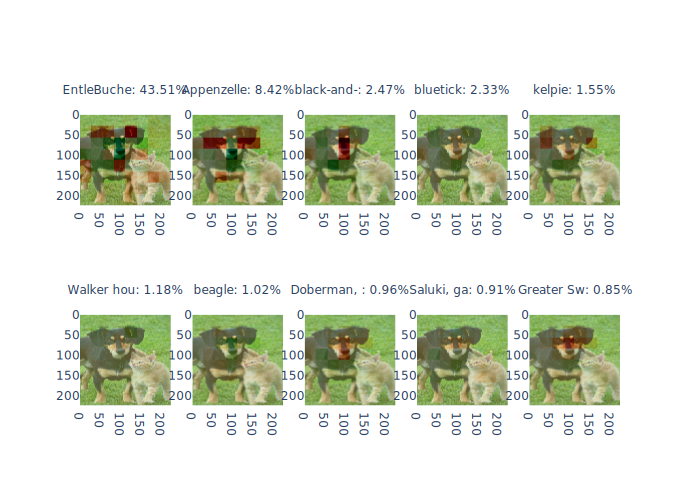

In [10]:

figures = []
probabilities = torch.softmax(classify(transform(np.array(image_show)).permute(1,2,0)),dim=1)[0]

clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)
ids = [clas for clas in args[:10]]
for i in args[:10]:
    mask = revel.importance_mask(lle_representation=explanation,segments=segments,id_class=i)
    colored = cm.get_cmap("RdYlGn")
    mask_j = colored(mask)
    mask_j = mask_j[:,:,:3]
    instance = revel.instance
    instance = instance.swapaxes(0,1).swapaxes(1,2)
    
    image_final =(mask_j*2+instance/np.max(instance))/3
    figure = go.Image(z=image_final*256)
    
    figures.append(figure)
    

name_clases = [f"{classes[clas.item()][:10]}: {100*probabilities[clas.item()]:.2f}%" for clas in ids]

fig = make_subplots(rows=2, cols=5, subplot_titles=name_clases,)


for i in range(2):
    for j in range(5):
        fig.add_trace(figures[i*5+j],row=i+1,col=j+1)

fig.update_annotations(font_size=12)
fig.show(renderer="svg")

We order the importance masks by most predicted percentage. As we see, the most important features are more realated to the nose and ears of the dog. The presence of the nose is quite characteristic to predict the class `EntleBucher`. The presence of the ears is also important but in a negative way. That is, the ears are more characteristic of other classes, even if the actual class is `EntleBucher`.

If we look at the importance masks of the class `Appenzelle`, the second most predicted class, we can see that the most important features are the presence of the nose again and the absence of the eyes. This is due to the fact that the `Appenzelle` is a dog with a similar nose to the `EntleBucher` but with a different eyes.

### Evaluation

The evaluation of the explanation is made by ReVel class. Let's obtain the five metrics of the explanation:

- `local_concordance`: This metric measures how similar the prediction of the model and the LLE are on the original example. The higher the value, the more similar they are. 
- `local_fidelity`: This metric measures how similar the prediction of the model and the LLE are on the neighbours of the original example. The higher the value, the more similar they are. This is a generalization of the local concordance.
- `prescriptivity`: 
- `conciseness`: This metric measures which percentage of the less important features has half of the importance of the explanation

In [12]:

display(f"Local concordance: {revel.local_concordance(explanation).item():.4f}")
neighbours = [[0 if j==i else 1 for j in range(revel.n_features) ] for i in range(revel.n_features)]
display(f"Local fidelity: {revel.local_fidelity(neighbours,explanation)}")
display(f"Prescriptivity: {revel.prescriptivity(explanation)}")
display(f"Conciseness: {revel.conciseness(explanation)}")

'Local concordance: 0.0001'

'Local fidelity: 0.22358410792637784'

'Prescriptivity: 0.260325463239656'

'Conciseness: 0.7612991424443339'